# MuseGAN Training

## imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#import zipfile
#zip_file=zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3/dataset/JSB-Chorales-dataset-master.zip")
#zip_file.extractall("/content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3/dataset/")

### 재실행 지점

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3

/content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3


In [4]:
!pwd

/content/drive/MyDrive/Colab Notebooks/mmm-project/museGANV3


In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types
import tensorflow as tf
import random
from models.MuseGAN import MuseGAN
from utils.loaders import load_music

from music21 import midi
from music21 import note, stream, duration

In [6]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(3037)

In [7]:
# run params
SECTION = 'compose'
RUN_ID = '10'
DATA_BASE = 'dataset'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])


if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))
    os.makedirs(os.path.join(RUN_FOLDER, 'samples'))

mode =  'build' # ' 'load' # 

In [8]:
RUN_FOLDER

'run/compose/10_chorales'

## data

In [9]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music( DATA_BASE +'/'+ DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)

In [10]:
data_binary.shape

(229, 2, 16, 84, 4)

## architecture

In [11]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:                 
    gan.load_weights(RUN_FOLDER)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
gan.chords_tempNetwork.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 temporal_input (InputLayer)  [(None, 32)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 1, 1024)       66560     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 2, 1, 1024)       4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2, 1, 1024)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 2, 1, 32)         3280

In [13]:
gan.barGen[0].summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bar_generator_input (InputL  [(None, 128)]            0         
 ayer)                                                           
                                                                 
 dense_2 (Dense)             (None, 1024)              132096    
                                                                 
 batch_normalization_10 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 1024)              0         
                                                                 
 reshape_10 (Reshape)        (None, 2, 1, 512)         0         
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 4, 1, 512)        5248

In [14]:
gan.generator.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 melody_input (InputLayer)      [(None, 4, 32)]      0           []                               
                                                                                                  
 chords_input (InputLayer)      [(None, 32)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 32)           0           ['melody_input[0][0]']           
                                                                                                  
 lambda_1 (Lambda)              (None, 32)           0           ['melody_input[0][0]']           
                                                                                           

In [15]:
gan.critic.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cond_input (InputLayer)        [(None, 2, 16, 84,   0           []                               
                                1)]                                                               
                                                                                                  
 critic_input (InputLayer)      [(None, 2, 16, 84,   0           []                               
                                4)]                                                               
                                                                                                  
 concatenate (Concatenate)      multiple             0           ['cond_input[0][0]',             
                                                                  'critic_input[0][0]']       

## training

In [16]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 10

In [17]:
gan.train(
    cond_input=data_binary[-BATCH_SIZE:, :, :, :, :1] # 배치사이즈 = 64, 마지막 1트랙만 조건부 입력
    , x_train=data_binary
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 (5, 1) [D loss: (9.6)(R -0.3, F -0.1, G 1.0)] [G loss: 0.3]


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


1 (5, 1) [D loss: (-312.7)(R -649.7, F -41.1, G 37.8)] [G loss: 83.4]
2 (5, 1) [D loss: (-225.3)(R -415.1, F -370.5, G 56.0)] [G loss: 114.2]
3 (5, 1) [D loss: (-254.9)(R 31.7, F -326.2, G 4.0)] [G loss: -1361.8]
4 (5, 1) [D loss: (-277.1)(R -2449.1, F 1651.6, G 52.0)] [G loss: -1230.8]
5 (5, 1) [D loss: (-315.9)(R -1499.4, F 1014.3, G 16.9)] [G loss: -1293.5]
6 (5, 1) [D loss: (-282.4)(R -1533.6, F 1052.4, G 19.9)] [G loss: -1325.0]
7 (5, 1) [D loss: (-228.3)(R -1348.3, F 990.6, G 12.9)] [G loss: -1283.4]
8 (5, 1) [D loss: (-169.0)(R -1211.8, F 958.2, G 8.5)] [G loss: -1210.5]
9 (5, 1) [D loss: (-116.1)(R -1093.7, F 926.3, G 5.1)] [G loss: -1105.5]
10 (5, 1) [D loss: (-84.5)(R -1076.9, F 961.5, G 3.1)] [G loss: -1095.7]
11 (5, 1) [D loss: (-76.6)(R -1076.2, F 976.4, G 2.3)] [G loss: -1121.1]
12 (5, 1) [D loss: (-78.9)(R -1051.7, F 923.1, G 5.0)] [G loss: -764.8]
13 (5, 1) [D loss: (-77.6)(R -967.8, F 855.0, G 3.5)] [G loss: -825.8]
14 (5, 1) [D loss: (-84.8)(R -1184.8, F 1048.4, G 5.2

KeyboardInterrupt: ignored

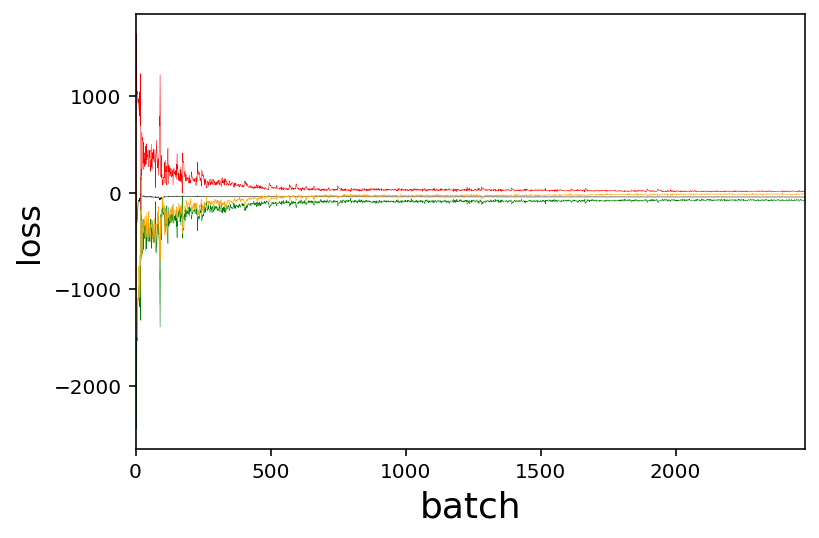

In [18]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()